In [29]:
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [15]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [59]:
image_folder = '/data2/ziyxiang/saycam_annotation/for_additional_panoptic/'

## GT segmentation mask on selected SAYCam images

In [31]:
gt_seg_path = '/data3/ziyxiang/saycam_seg_annotations/combined_good_segmentations.json'

In [32]:
gt_seg_annotations = json.load(open(gt_seg_path))

In [57]:
gt_seg_annotations['images'][0]

{'file_name': 'http://langcog.stanford.edu/expts/saycam/frames/10000-A_20141109_2527_01.mp4-22445.jpg',
 'height': 480,
 'width': 640,
 'id': 1}

In [42]:
gt_seg_annotations['categories']

[{'supercategory': 'none', 'id': 1, 'name': 'Book / iPad / Puzzle'},
 {'supercategory': 'none', 'id': 2, 'name': 'Ball'},
 {'supercategory': 'none', 'id': 3, 'name': 'Marker / Crayon'},
 {'supercategory': 'none', 'id': 4, 'name': 'Other toy'},
 {'supercategory': 'none', 'id': 5, 'name': 'Food'},
 {'supercategory': 'none', 'id': 6, 'name': 'Sippy cup / Bottle'},
 {'supercategory': 'none', 'id': 7, 'name': 'Utensil'},
 {'supercategory': 'none', 'id': 8, 'name': 'Musical instrument'},
 {'supercategory': 'none', 'id': 9, 'name': 'Shoe'},
 {'supercategory': 'none', 'id': 10, 'name': 'Hand'}]

In [88]:
gt_seg_annotations['annotations'][0]

{'segmentation': [[458.0,
   441.5,
   493.5,
   427.0,
   491.5,
   417.0,
   487.5,
   409.0,
   497.5,
   387.0,
   497.5,
   375.0,
   470.0,
   362.5,
   463.5,
   358.0,
   463.5,
   348.0,
   456.5,
   326.0,
   453.5,
   307.0,
   453.5,
   297.0,
   450.5,
   288.0,
   449.5,
   277.0,
   424.0,
   238.5,
   420.0,
   237.5,
   413.0,
   240.5,
   405.0,
   240.5,
   404.5,
   242.0,
   407.5,
   247.0,
   407.5,
   253.0,
   409.5,
   258.0,
   411.5,
   258.0,
   410.5,
   261.0,
   415.0,
   269.5,
   414.5,
   266.0,
   416.5,
   267.0,
   427.5,
   289.0,
   434.5,
   307.0,
   433.5,
   309.0,
   435.5,
   310.0,
   438.5,
   320.0,
   447.5,
   338.0,
   463.5,
   385.0,
   465.0,
   387.5,
   466.0,
   379.5,
   476.5,
   403.0,
   476.5,
   412.0,
   474.5,
   416.0,
   477.5,
   421.0,
   476.5,
   426.0,
   456.5,
   441.0],
  [],
  [],
  [106.0,
   478.5,
   104.5,
   459.0,
   91.5,
   380.0,
   91.5,
   377.0,
   96.5,
   374.0,
   80.5,
   357.0,
   137.0,
   34

In [87]:
gt_seg_sample = gt_seg_annotations['annotations'][0]

In [55]:
gt_seg_sample.keys()

dict_keys(['segmentation', 'iscrowd', 'image_id', 'category_id', 'id', 'bbox', 'area'])

In [82]:
height, width = 480, 640
mask = np.zeros((height, width))
seg_arr = np.array(gt_seg_sample['segmentation'][0], dtype=np.int32).reshape(-1, 2)
mask = cv2.fillPoly(mask, [seg_arr], color=(255))

visualize to see if annotations are indeed correct

In [60]:
image_path = os.path.join(image_folder, '10000-A_20141109_2527_01.mp4-22445.jpg')
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

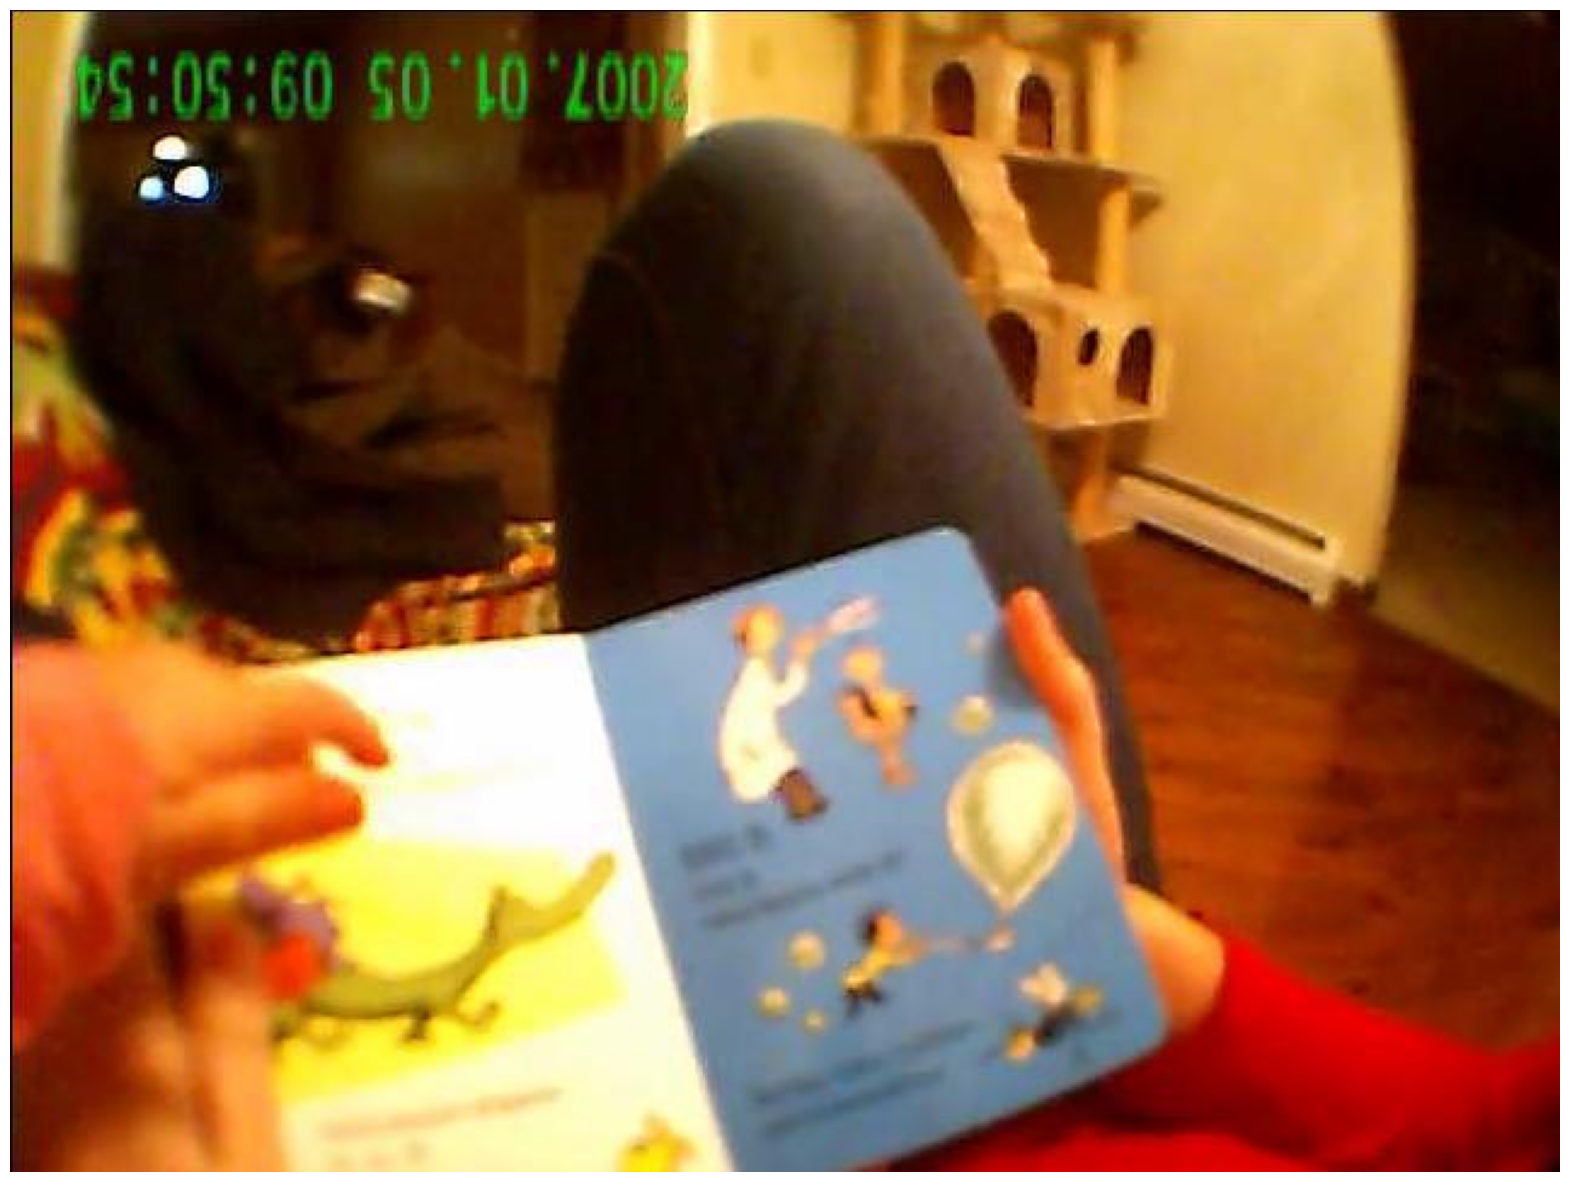

In [61]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

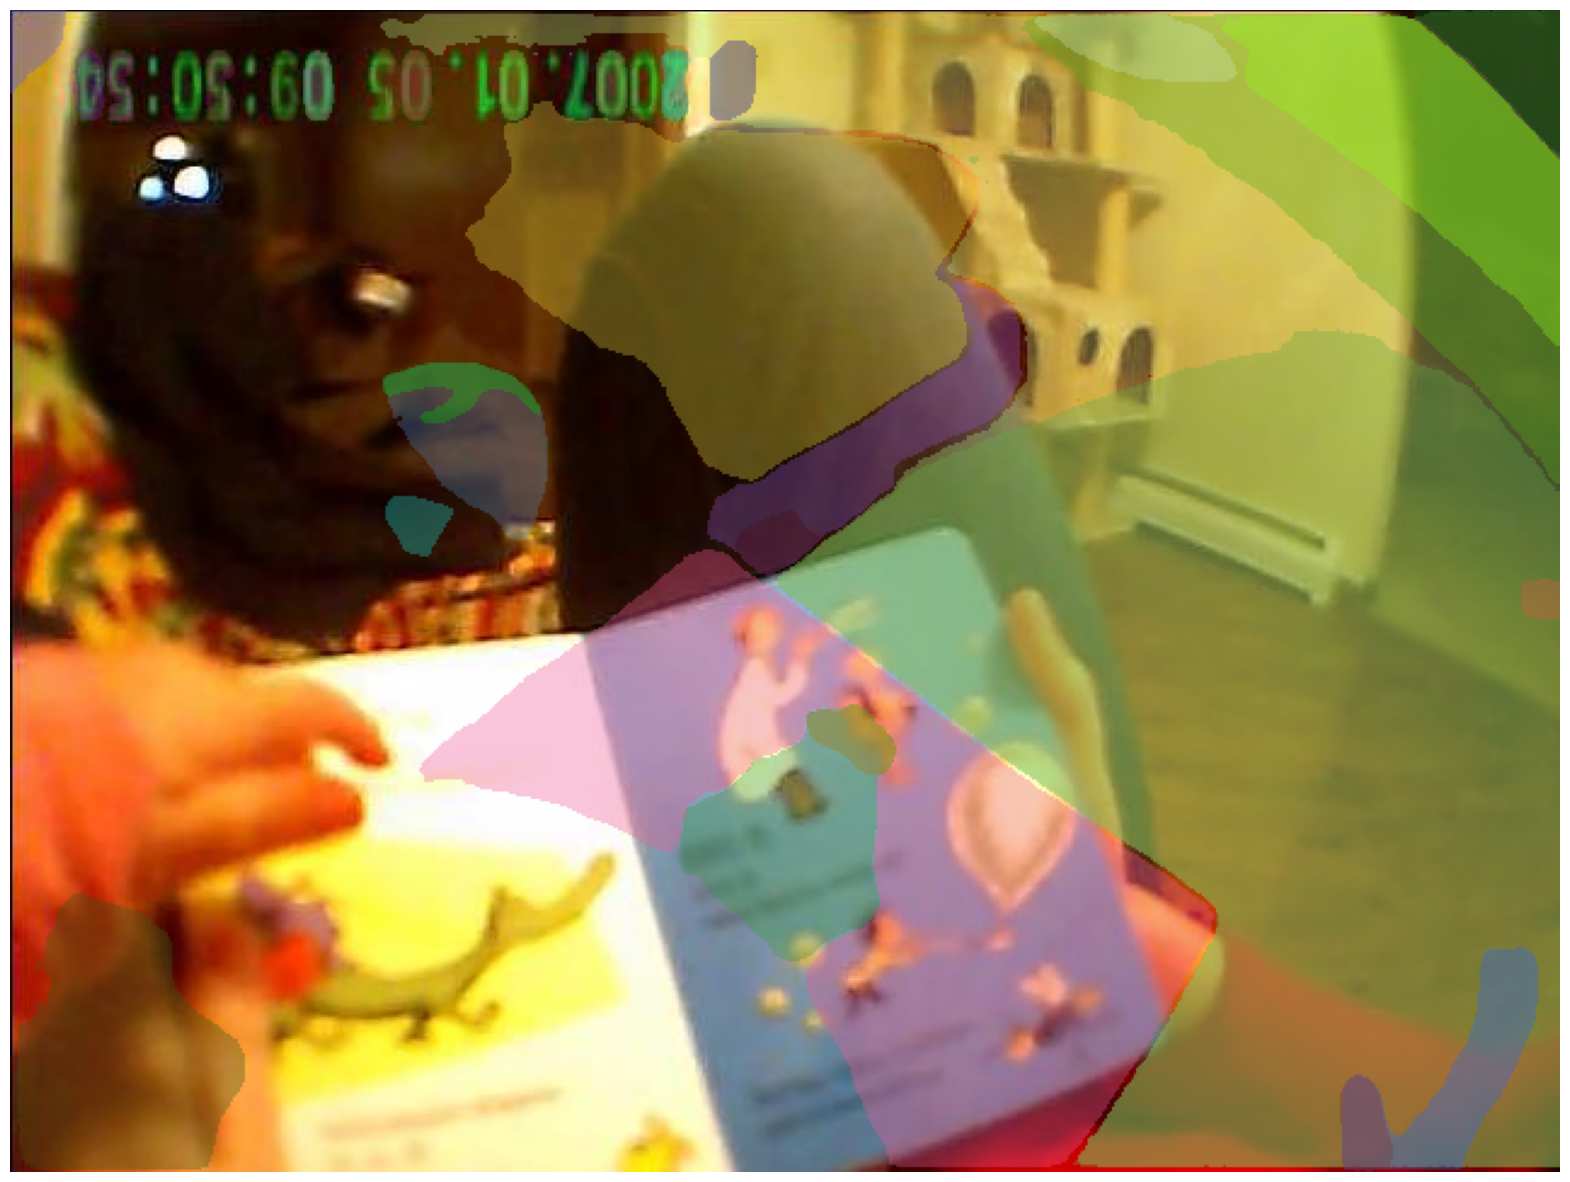

In [85]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation

### Load model

In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/data3/ziyxiang/sam_models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

### Images with masks

In [19]:
image_path = os.path.join(image_folder, '9963-A_20141103_2521_03.mp4-140.jpg')
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

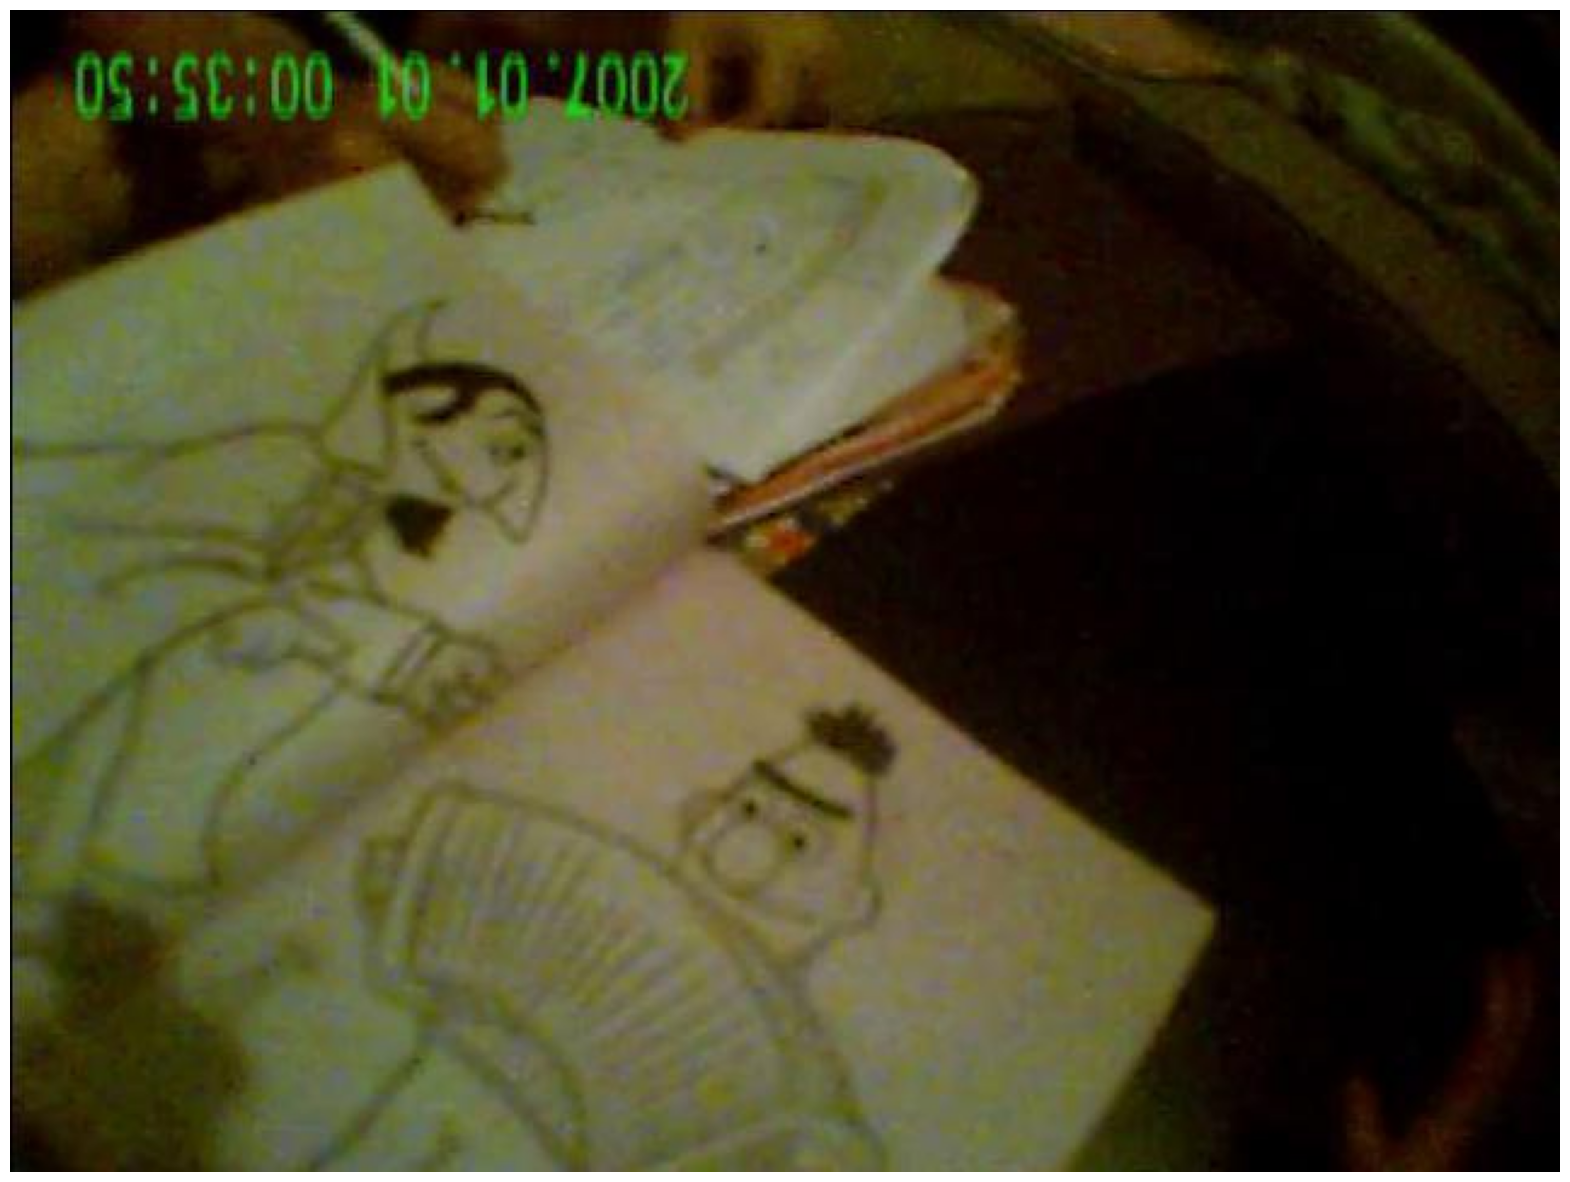

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [21]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [22]:
print(len(masks))
print(masks[0].keys())

34
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [28]:
masks

[{'segmentation': array([[False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 1801,
  'bbox': [580, 0, 59, 59],
  'predicted_iou': 1.0038257837295532,
  'point_coords': [[610.0, 7.5]],
  'stability_score': 0.9883913993835449,
  'crop_box': [0, 0, 640, 480]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 322,
  'bbox': [26, 17, 12, 28],
  'pre

Show all the masks overlayed on the image.

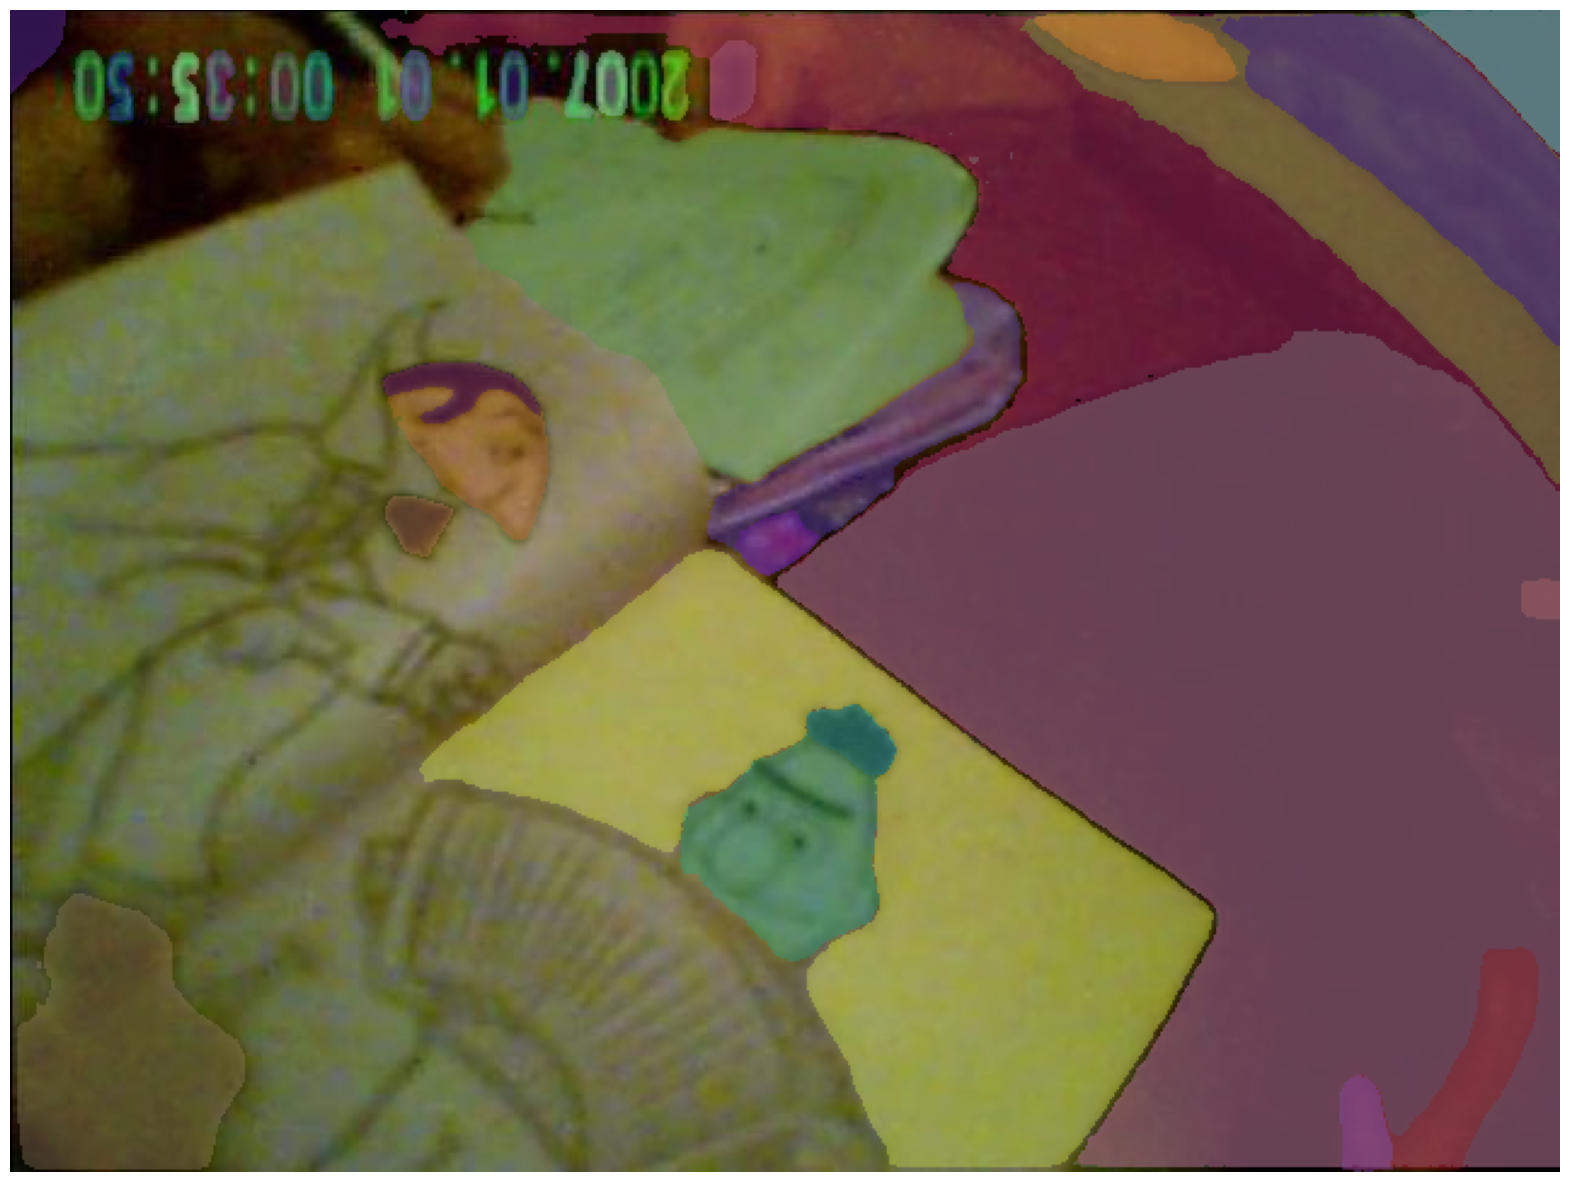

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [24]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [25]:
masks2 = mask_generator_2.generate(image)

In [26]:
len(masks2)

58

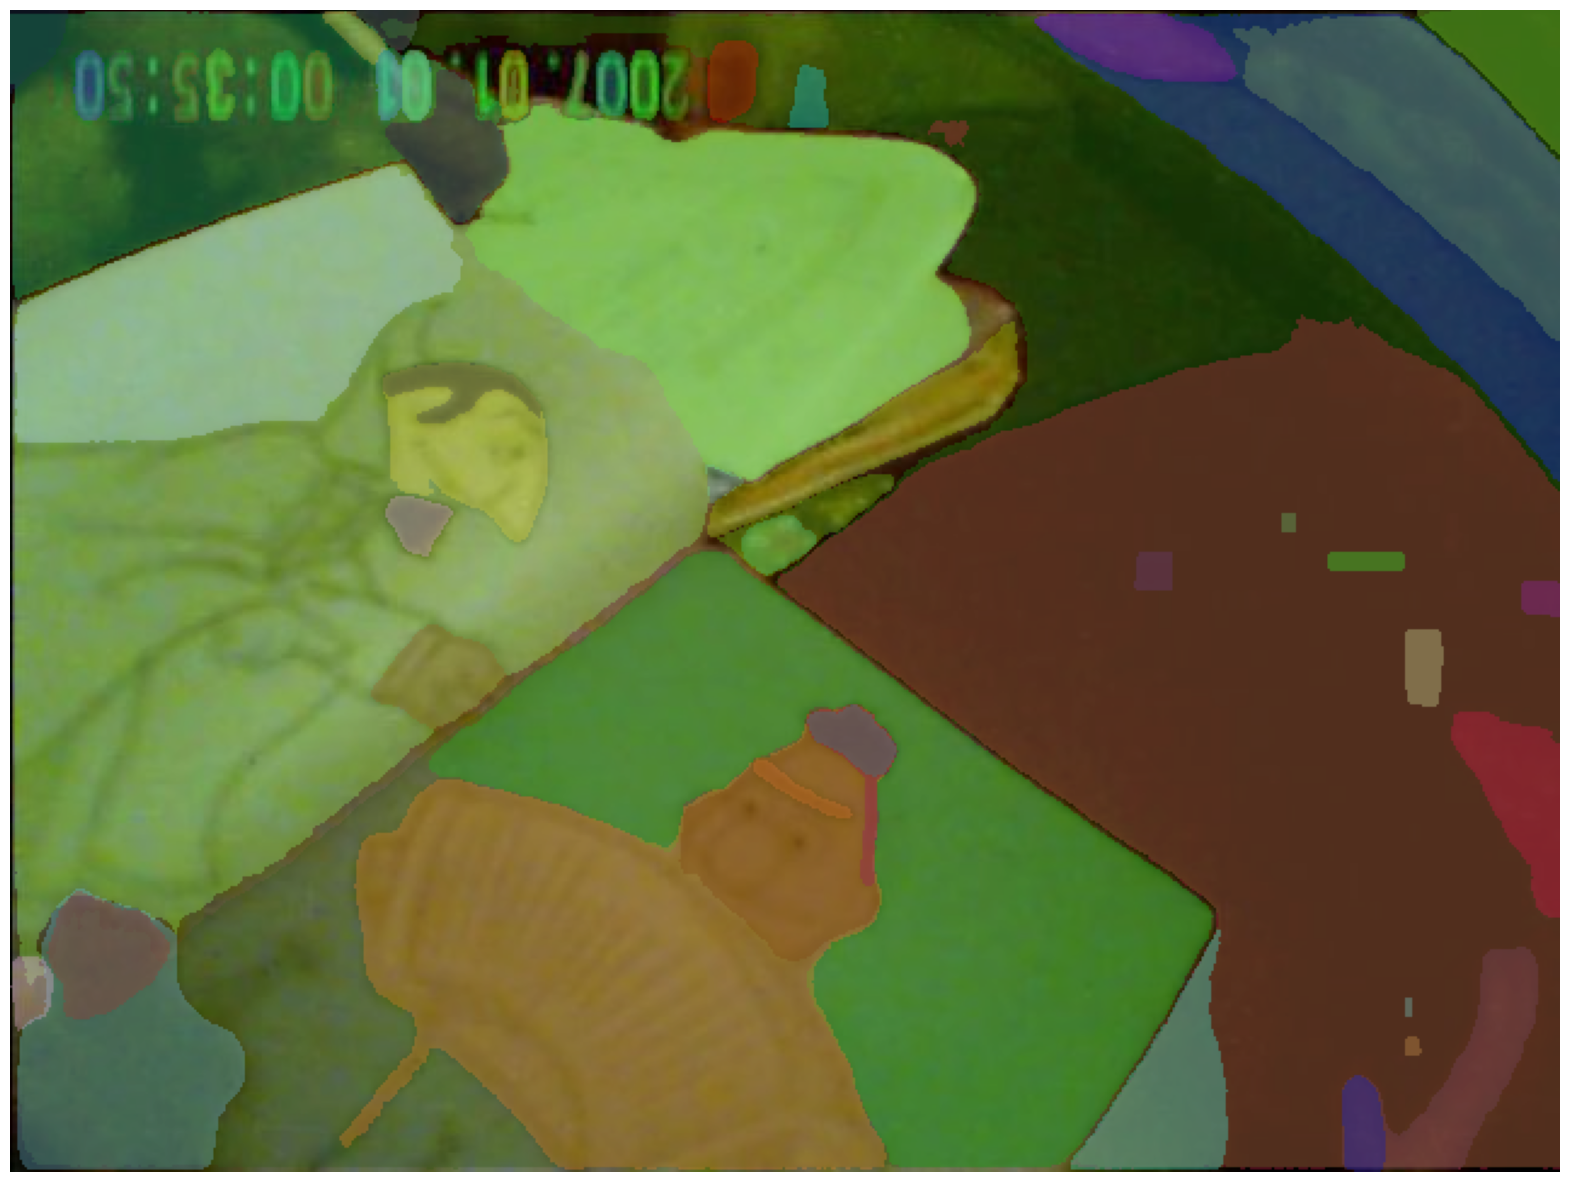

In [27]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 